# Defining the Spatial Domain in CONFLUENCE
## Introduction
In this notebook, we'll explore the different methods for defining the spatial domain in CONFLUENCE. The spatial domain is crucial as it determines the area of interest for our hydrological modeling. CONFLUENCE offers several options for domain definition, each suited to different needs and data availability.

## Setup
First, let's set up our environment and import the necessary modules:

In [1]:
import sys
from pathlib import Path

# Add the parent directory to sys.path
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
sys.path.append(str(parent_dir))

import yaml # type: ignore
from utils.geospatial_utils.geofabric_utils import GeofabricSubsetter, GeofabricDelineator, LumpedWatershedDelineator # type: ignore
import logging

# Load configuration
config_file = 'config_active.yaml'
config_path = parent_dir / '0_config_files' / config_file
with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Domain Definition Methods
## CONFLUENCE supports three main methods for defining the spatial domain:

1. Subsetting an existing geofabric
2. Delineating a lumped watershed
3. Delineating a new geofabric

Let's explore each of these methods.

# 1. Subsetting an Existing Geofabric

This method is useful when you have an existing geofabric and want to extract a portion of it for your study area. Confluence will subset the model domain upstream of the pour point we defined in notebook 0_initializeProject. CONFLUENCE currently supports the MERIT, TDX and NWS hydrofabrics

To use this method, set in config:

- DOMAIN_DEFINITION_METHOD: subset
- GEOFABRIC_TYPE: "Merit", "TDX" or "NWS"
- SOURCE_GEOFABRIC_BASINS_PATH: /path/to/source/geofabric_basins/geofabric_basins.shp
- SOURCE_GEOFABRIC_RIVERS_PATH: /path/to/source/geofabric_rivers/geofabric_rivers.shp
- OUTPUT_BASINS_PATH: /path/to/output/geofabric_basins/model_basins.shp
- OUTPUT_RIVERS_PATH: /path/to/output/geofabric_rivers/model_rivers.shp

Then call:
subset_geofabric()

In [2]:
def subset_geofabric():
    subsetter = GeofabricSubsetter(config, logger)
    subset_basins, subset_rivers = subsetter.subset_geofabric()
    
    if subset_basins is not None and subset_rivers is not None:
        logger.info("Geofabric subsetting completed successfully")
    else:
        logger.error("Geofabric subsetting failed")

## 2. Delineating a Lumped Watershed

This method creates a simple, single-unit watershed based on a pour point and DEM. CONFLUENCE allows for a choice whether to use the PySHEDS library or TauDEM for watershed delineation. 

To use this method, set in config:

- DOMAIN_DEFINITION_METHOD: lumped
- DEM_PATH: path/to/your/dem
- LUMPED_WATERSHED_METHOD: "pysheds" or "taudem"

Note, if you use numpy>2.0, you will need to `pip install git+https://github.com/ashleymedin/pysheds.git` instead of the standard pysheds, or you will get an error "TypeError: 'nodata' value not representable in dytype of array"

Then call: 
delineate_lumped_watershed()

In [3]:
def delineate_lumped_watershed():
    delineator = LumpedWatershedDelineator(config, logger)
    watershed_shapefile = delineator.delineate_lumped_watershed()
    
    if watershed_shapefile:
        logger.info(f"Lumped watershed delineation completed. Shapefile: {watershed_shapefile}")
    else:
        logger.error("Lumped watershed delineation failed")

## 3. Delineating a New Geofabric

This method creates a new, detailed geofabric for your study area using a DEM and pour point. This method uses the TauDEM (Terrain Analysis Using Digital Elevation Models) tools for watershed delineation which are available at https://github.com/dtarb/TauDEM. To use this functionality the TauDEM binaries need to be compiled and made available in the system PATH

To use this method, set in config:

- DOMAIN_DEFINITION_METHOD: delineate
- DEM_PATH: path/to/your/dem
- STREAM_THRESHOLD: Threshold flow accumulation for stream vectorisation
- TAUDEM_DIR: path/to/TauDEM/binaries

Then call: delineate_geofabric()

In [4]:
def delineate_geofabric():
    delineator = GeofabricDelineator(config, logger)
    river_network_path, river_basins_path = delineator.delineate_geofabric()
    
    if river_network_path and river_basins_path:
        logger.info(f"Geofabric delineation completed.")
        logger.info(f"River network: {river_network_path}")
        logger.info(f"River basins: {river_basins_path}")
    else:
        logger.error("Geofabric delineation failed")       

## Choosing the Right Method
The choice of domain definition method depends on your specific needs:

- Use subset_geofabric if you have an existing geofabric and want to focus on a specific area within it.
- Use delineate_lumped_watershed for simple, single-unit watershed studies or as a quick approximation.
- Use delineate_geofabric when you need a detailed, custom geofabric for your study area.

Remember to set the appropriate method in your configuration file before running the domain definition.

## Running the Domain Definition

Here's how you can run the domain definition based on the configuration:

In [5]:
def define_domain():
    domain_method = config.get('DOMAIN_DEFINITION_METHOD')
    
    if domain_method == 'subset':
        subset_geofabric()
    elif domain_method == 'lumped':
        delineate_lumped_watershed()
    elif domain_method == 'delineate':
        delineate_geofabric()
    else:
        logger.error(f"Unknown domain definition method: {domain_method}")

# Run the domain definition
define_domain()

2025-03-28 09:22:24,342 - INFO - Function source code:
    @get_function_logger
    def delineate_lumped_watershed(self) -> Optional[Path]:
        """
        Delineate a lumped watershed using either TauDEM or pysheds.

        Returns:
            Optional[Path]: Path to the delineated watershed shapefile, or None if delineation fails.
        """
        self.logger.info(f"Starting lumped watershed delineation for {self.domain_name}")

        if self.delineation_method.lower() == 'pysheds':
            return self.delineate_with_pysheds()
        else:  # default to TauDEM
            return self.delineate_with_taudem()


2025-03-28 09:22:24,343 - INFO - Starting lumped watershed delineation for Wolverine
2025-03-28 09:22:24,343 - INFO - Starting lumped watershed delineation for Wolverine
2025-03-28 09:22:24,825 - INFO - Created 1 records
2025-03-28 09:22:24,826 - INFO - Lumped watershed delineation completed using pysheds for Wolverine
2025-03-28 09:22:24,827 - INFO - Lumped wate

### Glacier Domains
Here we need to delineate off the bedrock topography, since glacier surfaces are convex (and thus will make incorrect catchments).

In [6]:
# import libraries
from pysheds.grid import Grid # type: ignore
import geopandas as gpd # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from shapely.geometry import Polygon

In [7]:
# Set up paths
data_dir = config['CONFLUENCE_DATA_DIR']
domain_name = config['DOMAIN_NAME']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"
dem_path = project_dir / 'attributes' / 'elevation' / 'dem' / f"domain_{config['DOMAIN_NAME']}_bedrock_elv.tif"

pour_point_path = config.get('POUR_POINT_SHP_PATH')
if pour_point_path == 'default':
     pour_point_path = project_dir / "shapefiles" / "pour_point"
else:
     pour_point_path = Path(pour_point_path)
if config['POUR_POINT_SHP_NAME'] == "default":
     pour_point_path = pour_point_path / f"{domain_name}_pourPoint.shp"

# get the delineation method
domain_method = config.get('DOMAIN_DEFINITION_METHOD')

In [8]:
# Only using pysheds at the moment
if domain_method == 'lumped':
    # Initialize grid from raster
    grid = Grid.from_raster(str(dem_path))

    # Read the (bottom) DEM
    dem = grid.read_raster(str(dem_path))

    # Read the pour point
    pour_point = gpd.read_file(pour_point_path)
    pour_point = pour_point.to_crs(grid.crs)
    x, y = pour_point.geometry.iloc[0].coords[0]

    # Condition DEM
    pit_filled_dem = grid.fill_pits(dem)
    flooded_dem = grid.fill_depressions(pit_filled_dem)
    inflated_dem = grid.resolve_flats(flooded_dem)

    # Compute flow direction
    fdir = grid.flowdir(inflated_dem)

    # Compute flow accumulation
    acc = grid.accumulation(fdir)

    # Snap pour point to high accumulation cell
    x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

    # Delineate the catchment
    catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

    # Create a binary mask of the catchment
    mask = np.where(catch, 1, 0).astype(np.uint8)
    
    # Convert the mask to a polygon
    shapes = rasterio.features.shapes(mask, transform=grid.affine)
    polygons = [Polygon(shape[0]['coordinates'][0]) for shape in shapes if shape[1] == 1]
    
    if not polygons:
        print("No watershed polygon generated.")
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=grid.crs)
    gdf = gdf.dissolve()  # Merge all polygons into one
    gdf['GRU_ID'] = 1
    gdf['gru_to_seg'] = 1
    gdf = gdf.to_crs('epsg:3763')
    gdf['GRU_area'] = gdf.geometry.area 
    gdf = gdf.to_crs('epsg:4326')
    
    # Save the watershed shapefile
    watershed_shp_path = project_dir / "shapefiles/river_basins" / f"{domain_name}_riverBasins_lumped.shp"
    gdf.to_file(watershed_shp_path)
    print(f"Lumped watershed delineation completed using pysheds for {domain_name}")
else:
    print(f"Domain definition method {domain_method} for glaciers not yet supported by this script.")

2025-03-28 09:22:25,334 - INFO - Created 1 records


Lumped watershed delineation completed using pysheds for Wolverine


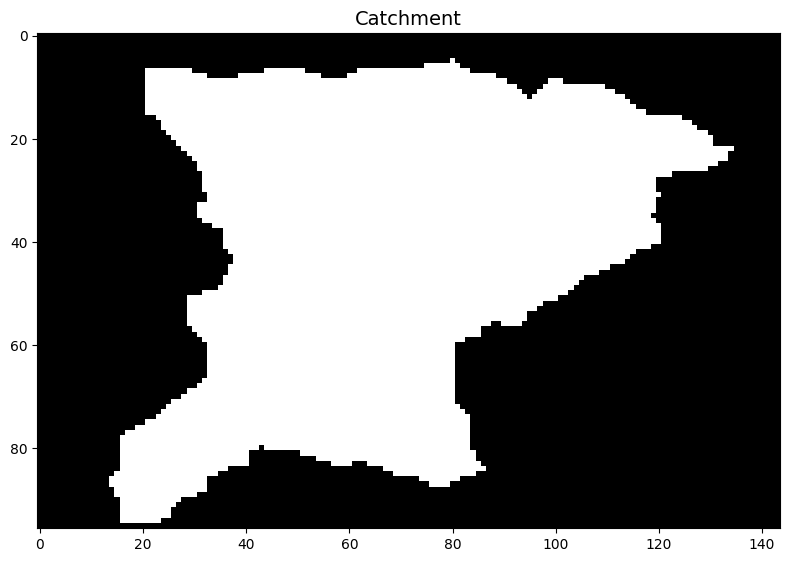

In [9]:
# Plot the catchment
catch_view = grid.view(catch)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(catch_view, cmap='Greys_r', zorder=1)
plt.title('Catchment', size=14)
plt.tight_layout()

In [10]:
def inundate_cells(dem_surf,dem,origxy, id, glacier_id, cellxy, glac_extPossible, hand, glacier_height, this_extend, ncell, cell_added):
    """
    Recursively inundate cells around the current cell if conditions are met.

    Parameters:
    - cellxy: Tuple of the current cell coordinates (x, y).
    - glac_extPossible: Array indicating the glacier extent.
    - hand: HAND raster (Height Above Nearest Drainage).
    - glacier_height: Height of the glacier.
    - this_extend: Array tracking the extended glacier area.
    - ncell: Maximum number of cells to add.
    - cell_added: Current count of added cells.

    Returns:
    - Updated this_extend and cell_added.
    """
    surround = {0: (0, -1), 1: (1, -1), 2: (1, 0), 3: (1, 1),
                4: (0, 1), 5: (-1, 1), 6: (-1, 0), 7: (-1, -1)}

    # Iterate over the 8 surrounding cells
    for i in range(8):
        surround_cell = surround[i]
        new_x, new_y = cellxy[0] + surround_cell[0], cellxy[1] + surround_cell[1]

        # Check if the new cell is within bounds
        if 0 <= new_y < glac_extPossible.shape[0] and 0 <= new_x < glac_extPossible.shape[1]:
            # Check if the cell can be inundated
            if glac_extPossible[new_y, new_x] == 1 and hand[new_y, new_x] < glacier_height and this_extend[new_y, new_x] == 0 and dem[new_y, new_x] <= dem_surf[origxy[1], origxy[0]]:
                this_extend[new_y, new_x] = 1
                if id[new_y, new_x] != glacier_id: cell_added += 1

                # Stop if the maximum number of cells has been added
                if cell_added >= ncell:
                    return this_extend, cell_added

                # Recursively inundate from the new cell
                this_extend, cell_added = inundate_cells(dem_surf, dem, origxy,id, glacier_id,
                    (new_x, new_y), glac_extPossible, hand, glacier_height, this_extend, ncell, cell_added
                )

                # Stop if the maximum number of cells has been added
                if cell_added >= ncell:
                    return this_extend, cell_added

    return this_extend, cell_added

In [11]:
# read in glacier id raster and extend glacier id downstream to the catchment boundary (unless runs into another glacier)
glacier_dir = project_dir / 'attributes' / 'glaciers'
id_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_glacier_id.tif" # only for glacier cells, not glacierets
id = rasterio.open(id_path).read(1)
meta = rasterio.open(id_path).meta.copy()
type_path = glacier_dir / f"domain_{config['DOMAIN_NAME']}_domain_type.tif" # glacier or glacieret
type = rasterio.open(type_path).read(1)
dem_surf_path = project_dir / 'attributes' / 'elevation' / 'dem' / f"domain_{config['DOMAIN_NAME']}_elv.tif"
dem_surf = rasterio.open(dem_surf_path).read(1)

# get possible glacier extend
glac_extPossible = np.zeros_like(id)
glac_extPossible[catch == 1] = 1
glac_extPossible[(id>0) | type!=1]=0 # only expand to land and not into other glaciers
thresh_expand = 0.1 # threshold (area fraction) for expanding glacier extent
hand = grid.compute_hand(fdir, dem, acc > 100) # compute height above nearest drainage

# remove glaciers that are not mostly in the catchment
unique_glaciers = np.unique(id)
unique_glaciers = unique_glaciers[unique_glaciers != 0] # remove 0 from list
threshold = 0.8 # threshold for glacier cells that must be in gru to be included (should be 1.0 but DEMs are not perfect)
filtered_glaciers = []
for glacier_id in unique_glaciers:
    glacier_all_count = np.sum(id == glacier_id)
    glacier_catch_count = np.sum((id == glacier_id) & catch)
    if glacier_catch_count >= threshold * glacier_all_count:
        filtered_glaciers.append(glacier_id)
unique_glaciers = np.array(filtered_glaciers)

# Do by unique glacier ID, starting with the largest glacier
order = np.argsort(np.bincount(id.flatten())[unique_glaciers])[::-1]
unique_glaciers = unique_glaciers[order]
extension_method = 'drag' # 'drag' or 'fill'

In [12]:
# loop through glaciers
# method 1: drag glacier downstream
if extension_method == 'drag':
    for glacier_id in unique_glaciers:

        # find location of glacier terminus
        acc_glacier = acc.copy()
        acc_glacier[id != glacier_id] = 0
        y, x = np.where(acc_glacier>=np.percentile(acc_glacier[acc_glacier>0], 100))
        gridyx = (y[0],x[0])
        ext_shape0 = np.zeros_like(id)
        ext_shape0[gridyx[0],gridyx[1]] = 1
        ext_shape0 = grid.catchment(x=gridyx[1], y=gridyx[0], fdir=fdir, xytype='index')
        ext_shape0 = np.where(ext_shape0, 1, 0).astype(np.uint8) # Create a binary mask of the catchment
        ext_shape0[id!=glacier_id] = 0 # only keep glacier cells

        # find location a bit upstream of the glacier terminus
        percentile = 100
        y1, x1 = y, x
        n=0
        ext_shape1 = ext_shape0.copy()
        while (y1[n] == y[0] and x1[n] == x[0]) or (ext_shape0 - ext_shape1).sum() < 2:
            percentile = percentile - 0.1
            y1, x1 = np.where(acc_glacier>=np.percentile(acc_glacier[acc_glacier>0], percentile))
            n=acc_glacier[y1,x1].argmin() # find location of minimum accumulation, most upstream
            gridyx = (y1[n],x1[n])
            ext_shape1 = grid.catchment(x=gridyx[1], y=gridyx[0], fdir=fdir, xytype='index')
            ext_shape1 = np.where(ext_shape1, 1, 0).astype(np.uint8) # Create a binary mask of the catchment
            ext_shape1[id!=glacier_id] = 0 # only keep glacier cells

        # cut out small bit of terminus
        ext_shape = ext_shape0 - ext_shape1
        # if extent shape is only 1 cell thick, expand to 2 cells thick
        surround = {0: (0, -1), 1: (1, -1), 2: (1, 0), 3: (1, 1),
                    4: (0, 1), 5: (-1, 1), 6: (-1, 0), 7: (-1, -1)}
        y,x = np.where(ext_shape==1)
        for i in range(x.size):
            if np.sum(ext_shape[y[i]-1:y[i]+2,x[i]-1:x[i]+2]) <=4:
                # Iterate over the 8 surrounding cells
                for j in range(8):
                    surround_cell = surround[j]
                    new_x, new_y = x[i] + surround_cell[0], y[i] + surround_cell[1]
                    if 0 <= new_y < ext_shape.shape[0] and 0 <= new_x < ext_shape.shape[1]:
                        if ext_shape0[new_y,new_x] == 1: ext_shape[new_y,new_x] = 1
        size_ext_shape = ext_shape.sum()

        # expand the glacier extent from the glacier pour point over glac_extPossible by dragging downstream till hit threshold
        ncell = int((acc_glacier[acc_glacier>0].size)**(2./3.)) #*thresh_expand)
        this_extend = ext_shape
        cell_added = 0 # still in current glacier
        cellxy = gridyx[1], gridyx[0]
        nextcells = {64: (0, -1), 128: (1, -1), 1: (1, 0), 2: (1, 1), 4: (0, 1), 8: (-1, 1), 16: (-1, 0), 32: (-1, -1)}
        glac_extPossible0 = glac_extPossible.copy()
        glac_extPossible0[id == glacier_id] = 1 # add glacier cells to possible glacier extent so can expand to side of glacier

        # Expand the glacier extent
        while cell_added < ncell:
            # Get the next cell touching from fdir
            nextcell = nextcells[fdir[cellxy[1], cellxy[0]]]
            new_x, new_y = cellxy[0] + nextcell[0], cellxy[1] + nextcell[1]
            if 0 <= new_y < glac_extPossible.shape[0] and 0 <= new_x < glac_extPossible.shape[1]:
                if glac_extPossible0[new_y, new_x] == 1:
                    # shift all of shape if possible
                    new_shape = np.zeros_like(ext_shape)
                    y,x = np.where(ext_shape==1)
                    for i in range(x.size):
                        x0, y0 = x[i] + nextcell[0], y[i] + nextcell[1]
                        if 0 <= y0 < glac_extPossible.shape[0] and 0 <= x0 < glac_extPossible.shape[1]:
                            new_shape[y0,x0] = 1
                            
                    new_shape[glac_extPossible0==0] == 0
                    this_extend[new_shape == 1] = 1
                    cell_added = cell_added + new_shape[glac_extPossible==1].sum() # only count if not already glacier cell
                    glac_extPossible[this_extend == 1] = 0
                    ext_shape = new_shape
                    cellxy = (new_x, new_y)
                else: # stop if cannot expand further
                    break
            else: # stop if cannot expand further
                break
        # check this_extend for holes between glacier cells and fill
        y,x = np.where(this_extend==0)
        for i in range(x.size):
            # not out of bounds
            if y[i]>0 and y[i]<this_extend.shape[0]-1 and x[i]>0 and x[i]<this_extend.shape[1]-1:
                if np.sum(this_extend[y[i]-1:y[i]+2,x[i]-1:x[i]+2]) == 8:
                    if glac_extPossible[y[i],x[i]] == 1:
                        this_extend[y[i],x[i]] = 1
                        cell_added = cell_added + 1
        
        print(f"Glacier {glacier_id} expanded by {cell_added} cells with shape {size_ext_shape}, {ncell} cells requested")

        # add the expanded glacier extent to the glacier id raster
        id[this_extend == 1] = glacier_id

        # make glac_extPossible 0 where the glacier was already expanded
        glac_extPossible[this_extend == 1] = 0

Glacier 109162 expanded by 68 cells with shape 17, 247 cells requested


In [13]:
# loop through glaciers
# method 2: fill from end of glacier up surrounding cells if downstream and HAND is lower than a resprentative glacier terminus height
if extension_method == 'fill':
    for glacier_id in unique_glaciers:
    
        # find location of glacier terminus
        acc_glacier = acc.copy()
        acc_glacier[id != glacier_id] = 0
        y, x = np.where(acc_glacier>=np.percentile(acc_glacier[acc_glacier>0], 100))
        gridyx = (y[0],x[0])
        ext_shape0 = np.zeros_like(id)
        ext_shape0[gridyx[0],gridyx[1]] = 1
        ext_shape0 = grid.catchment(x=gridyx[1], y=gridyx[0], fdir=fdir, xytype='index')
        ext_shape0 = np.where(ext_shape0, 1, 0).astype(np.uint8) # Create a binary mask of the catchment
        ext_shape0[id!=glacier_id] = 0 # only keep glacier cells

        # find location a bit upstream of the glacier terminus
        percentile = 100
        y1, x1 = y, x
        n=0
        ext_shape1 = ext_shape0.copy()
        while (y1[n] == y[0] and x1[n] == x[0]) or (ext_shape0 - ext_shape1).sum() < 2:
            percentile = percentile - 0.1
            y1, x1 = np.where(acc_glacier>=np.percentile(acc_glacier[acc_glacier>0], percentile))
            n=acc_glacier[y1,x1].argmin() # find location of minimum accumulation, most upstream
            gridyx = (y1[n],x1[n])
            ext_shape1 = grid.catchment(x=gridyx[1], y=gridyx[0], fdir=fdir, xytype='index')
            ext_shape1 = np.where(ext_shape1, 1, 0).astype(np.uint8) # Create a binary mask of the catchment
            ext_shape1[id!=glacier_id] = 0 # only keep glacier cells
    
        # expand the glacier extent from the glacier pour point over glac_extPossible by using the hand raster until thresh_expand is reached
        ncell = int((acc_glacier[acc_glacier>0].size)**(2./3.)) #*thresh_expand)
        this_extend = np.zeros_like(id)
        cell_added = 0
        cellxy = gridyx[1], gridyx[0]
        nextcells = {64: (0, -1), 128: (1, -1), 1: (1, 0), 2: (1, 1), 4: (0, 1), 8: (-1, 1), 16: (-1, 0), 32: (-1, -1)}
        thickness_height = dem_surf[cellxy[1], cellxy[0]] - dem[cellxy[1], cellxy[0]] # thickness of glacier at starting point
        hand_height = hand[cellxy[1], cellxy[0]]
        glacier_height = max(hand_height, thickness_height,50.0) # minimum glacier height
        glac_extPossible0 = glac_extPossible.copy()
        glac_extPossible0[id == glacier_id] = 1 # add glacier cells to possible glacier extent so can expand to side of glacier
        
        # Expand the glacier extent
        while cell_added < ncell:
            # Get the next cell touching from fdir
            nextcell = nextcells[fdir[cellxy[1], cellxy[0]]]
            new_x, new_y = cellxy[0] + nextcell[0], cellxy[1] + nextcell[1]
            if 0 <= new_y < glac_extPossible.shape[0] and 0 <= new_x < glac_extPossible.shape[1]:
                if glac_extPossible0[new_y, new_x] == 1:
                    this_extend[new_y, new_x] = 1
                    if id[new_y, new_x] != glacier_id: cell_added += 1 # only count if not already glacier cell
                    cellxy = (new_x, new_y)
    
                    # Recursively inundate surrounding cells
                    this_extend, cell_added = inundate_cells(dem_surf,dem, (gridyx[1], gridyx[0]), id, glacier_id, 
                        cellxy, glac_extPossible0, hand, glacier_height, this_extend, ncell, cell_added
                    )
                else: # stop if cannot expand further
                    break
            else: # stop if cannot expand further
                break
        print(f"Glacier {glacier_id} expanded by {cell_added} cells to height {int(glacier_height)} m, {ncell} cells requested")
        
        # add the expanded glacier extent to the glacier id raster
        id[this_extend == 1] = glacier_id
    
        # make glac_extPossible 0 where the glacier was already expanded
        glac_extPossible[this_extend == 1] = 0

In [14]:
# Save the glacier id raster
output_file = glacier_dir / f"domain_{config['DOMAIN_NAME']}_glacier_id_extend.tif"
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(id, 1)

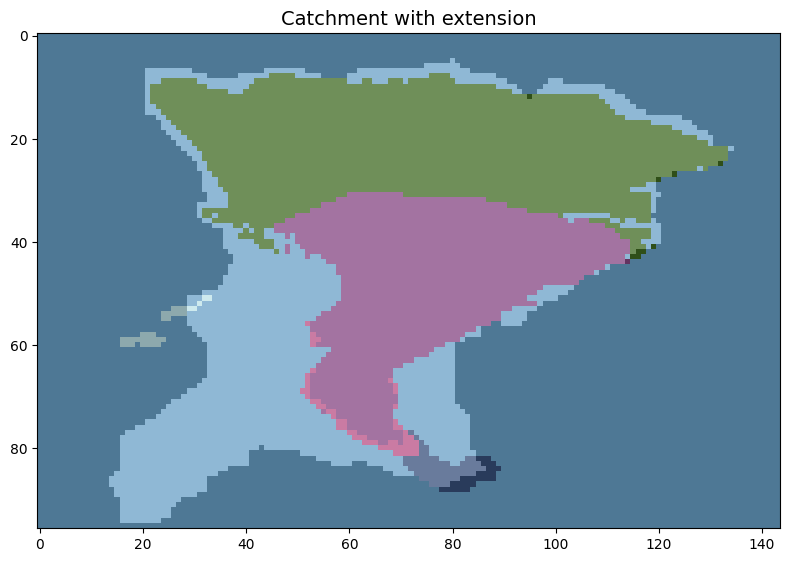

In [15]:
# plot new glacier extent in catchment only
catch_view = grid.view(catch)
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(id, cmap='Reds', alpha=0.5, zorder=2)
plt.imshow(type, cmap='tab20', alpha=0.5, zorder=2)
plt.imshow(catch_view, cmap='Greys_r', zorder=1)
plt.title('Catchment with extension', size=14)
plt.tight_layout()

# Conclusion

We've explored the three methods for defining the spatial domain in CONFLUENCE: subsetting an existing geofabric, delineating a lumped watershed, and delineating a new geofabric. Each method has its advantages and is suited to different scenarios. By choosing the appropriate method and configuring it correctly, you can define the spatial domain that best fits your hydrological modeling needs.

In the next notebook, we'll look at how to process finalise the process of preparing your spatial domain representation, including optional domain discretisation by dominant geospatial attributes.